# [COM4513-6513] Assignment 1: Text Classification with Logistic Regression

### Instructor: Nikos Aletras


The goal of this assignment is to develop and test two text classification systems: 

- **Task 1:** sentiment analysis, in particular to predict the sentiment of movie review, i.e. positive or negative (binary classification).
- **Task 2:** topic classification, to predict whether a news article is about International issues, Sports or Business (multiclass classification).


For that purpose, you will implement:

- Text processing methods for extracting Bag-Of-Word features, using (1) unigrams, bigrams and trigrams to obtain vector representations of documents. Two vector weighting schemes should be tested: (1) raw frequencies (**3 marks; 1 for each ngram type**); (2) tf.idf (**1 marks**). 
- Binary Logistic Regression classifiers that will be able to accurately classify movie reviews trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 1. 
- Multiclass Logistic Regression classifiers that will be able to accurately classify news articles trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 2. 
- The Stochastic Gradient Descent (SGD) algorithm to estimate the parameters of your Logistic Regression models. Your SGD algorithm should:
    - Minimise the Binary Cross-entropy loss function for Task 1 (**3 marks**)
    - Minimise the Categorical Cross-entropy loss function for Task 2 (**3 marks**)
    - Use L2 regularisation (both tasks) (**1 mark**)
    - Perform multiple passes (epochs) over the training data (**1 mark**)
    - Randomise the order of training data after each pass (**1 mark**)
    - Stop training if the difference between the current and previous validation loss is smaller than a threshold (**1 mark**)
    - After each epoch print the training and development loss (**1 mark**)
- Discuss how did you choose hyperparameters (e.g. learning rate and regularisation strength)?  (**2 marks; 0.5 for each model in each task**).
- After training the LR models, plot the learning process (i.e. training and validation loss in each epoch) using a line plot (**1 mark; 0.5 for both BOW-count and BOW-tfidf LR models in each task**) and discuss if your model overfits/underfits/is about right.
- Model interpretability by showing the most important features for each class (i.e. most positive/negative weights). Give the top 10 for each class and comment on whether they make sense (if they don't you might have a bug!).  If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain? (**2 marks; 0.5 for BOW-count and BOW-tfidf LR models respectively in each task**)


### Data - Task 1 

The data you will use for Task 1 are taken from here: [http://www.cs.cornell.edu/people/pabo/movie-review-data/](http://www.cs.cornell.edu/people/pabo/movie-review-data/) and you can find it in the `./data_sentiment` folder in CSV format:

- `data_sentiment/train.csv`: contains 1,400 reviews, 700 positive (label: 1) and 700 negative (label: 0) to be used for training.
- `data_sentiment/dev.csv`: contains 200 reviews, 100 positive and 100 negative to be used for hyperparameter selection and monitoring the training process.
- `data_sentiment/test.csv`: contains 400 reviews, 200 positive and 200 negative to be used for testing.

### Data - Task 2

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.


### Submission Instructions

You should submit a Jupyter Notebook file (assignment1.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc..

Please make sure to comment your code. You should also mention if you've used Windows (not recommended) to write and test your code. There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module.

The deadline for this assignment is **23:59 on Fri, 20 Mar 2020** and it needs to be submitted via MOLE. Standard departmental penalties for lateness will be applied. We use a range of strategies to detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index), including Turnitin which helps detect plagiarism, so make sure you do not plagiarise.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
import math

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)

## Load Raw texts and labels into arrays

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
# fill in your code...
data_dev = pd.read_csv("./data_sentiment/dev.csv",header=None, names=['text','label'])
data_test = pd.read_csv("./data_sentiment/test.csv",header=None, names=['text','label'])
data_tr = pd.read_csv("./data_sentiment/train.csv",header=None, names=['text','label'])

In [3]:
type(data_tr)

pandas.core.frame.DataFrame

If you use Pandas you can see a sample of the data.

In [4]:
data_tr.head()

,text,label
0,note : some may consider portions of the follo...,1
1,note : some may consider portions of the follo...,1
2,every once in a while you see a film that is s...,1
3,"when i was growing up in 1970s , boys in my sc...",1
4,"the muppet movie is the first , and the best m...",1


The next step is to put the raw texts into Python lists and their corresponding labels into NumPy arrays:


In [5]:
# Put the raw texts into list
# training dataset
data_tr_list = data_tr['text'].tolist()
data_tr_label = np.array(data_tr['label'])
# development dataset
data_dev_list = data_dev['text'].tolist()
data_dev_label = np.array(data_dev['label'])
# test dataset
data_test_list = data_test['text'].tolist()
data_test_label = np.array(data_test['label'])

# Bag-of-Words Representation 


To train and test Logisitc Regression models, you first need to obtain vector representations for all documents given a vocabulary of features (unigrams, bigrams, trigrams).


## Text Pre-Processing Pipeline

To obtain a vocabulary of features, you should: 
- tokenise all texts into a list of unigrams (tip: using a regular expression) 
- remove stop words (using the one provided or one of your preference) 
- compute bigrams, trigrams given the remaining unigrams
- remove ngrams appearing in less than K documents
- use the remaining to create a vocabulary of unigrams, bigrams and trigrams (you can keep top N if you encounter memory issues).


In [6]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
             'it', 'he', 'she', 'we', 'they' 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what', 
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

### N-gram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.

See the examples below to see how this function should work.

In [7]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):
    # Next it is my part to finish the this part
    # Create a new blank list
    x = list()
    ngram_list = list()
    # judge the variable type
    if type(x_raw) == type("string"):
        x_raw = list([x_raw])
    
    for x_each in x_raw:
        x_findword = re.findall(token_pattern,x_each)
        # Now we have obtained the new word list without the stop_word 
        x_rawall = [word for word in x_findword if word not in stop_words]
        store_ngram = list()
        for n_g in range(min(ngram_range),max(ngram_range)+1):
            for i in range(len(x_rawall)-n_g+1):
                if n_g == 1:
                    ngramTemp = x_rawall[i]
                    x.append(ngramTemp)
                    store_ngram.append(ngramTemp)
                elif n_g == 2 or n_g == 3:
                    ngramTemp = tuple(x_rawall[i:i+n_g])
                    x.append(ngramTemp)
                    store_ngram.append(ngramTemp)
        ngram_list.append(store_ngram)      
    # Now we should make the x into a set and 
    if vocab: 
        x = set(x) & vocab   
        return x
    else:
        return ngram_list

In [8]:
extract_ngrams("this is a great movie to watch", 
               ngram_range=(1,3), 
               stop_words=stop_words)

[['great',
  'movie',
  'watch',
  ('great', 'movie'),
  ('movie', 'watch'),
  ('great', 'movie', 'watch')]]

In [9]:
extract_ngrams("this is a great movie to watch", 
               ngram_range=(1,2), 
               stop_words=stop_words, 
               vocab=set(['great',  ('great','movie')]))

{('great', 'movie'), 'great'}

Note that it is OK to represent n-grams using lists instead of tuples: e.g. `['great', ['great', 'movie']]`

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab

Hint: it should make use of the `extract_ngrams` function.

In [10]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', min_df=0, keep_topN=0, stop_words=[]):
    
    # Firstly we should obtain the all the ngram list 
    # From the previous function this function will choose the putput type due to the input variables
    vocab = extract_ngrams(x_raw=X_raw, stop_words=stop_words)
    
    df = dict() #dict that contains ngrams as keys and their corresponding document frequency as values.
    ngram_counts= list() # type is the list and stores the number of words which occur at the text
    
    for each_ngram in vocab:
        for ngram in set(each_ngram):
            if ngram not in df.keys():
                df[ngram] = 1
            else:
                df[ngram] +=1

    df = dict(sorted(df.items(), key=lambda count:count[1], reverse=True)[:keep_topN])
    vocab = [name for name in df.keys()]
    
    for item in df.keys():
        ngram_counts.append(item)
    
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [11]:
X_tr_raw = data_tr_list
vocab, df, ngram_counts = get_vocab(X_tr_raw, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(list(df.items())[:10])
# print(df.most_common()[:10])

5000

['but', 'one', 'film', 'not', 'all', 'movie', 'out', 'so', 'there', 'like', 'more', 'up', 'about', 'when', 'some', 'if', 'just', 'only', 'into', 'than', 'even', 'their', 'time', 'most', 'no', 'good', 'much', 'him', 'would', 'other', 'get', 'story', 'well', 'will', 'also', 'two', 'after', 'first', 'character', 'make', 'way', 'characters', 'off', 'see', 'very', 'while', 'does', 'any', 'where', 'too', 'little', 'plot', 'because', 'over', 'director', 'had', 'how', 'then', 'best', 'being', 'people', 'doesn', 'really', 'man', 'never', 'life', 'through', 'films', 'here', 'don', 'many', 'another', 'such', 'scene', 'me', 'bad', 'know', 'made', 'scenes', 'my', 'end', 'new', 'go', 'before', 'back', 'makes', 'something', 'great', 'work', 'movies', 'still', 'better', 'now', 'few', 'down', 'seems', 'around', 'every', 're', 'enough']

[('but', 1334), ('one', 1247), ('film', 1231), ('not', 1170), ('all', 1117), ('movie', 1095), ('out', 1080), ('so', 1047), ('there', 1046), ('like', 1043)]


Then, you need to create vocabulary id -> word and id -> word dictionaries for reference:

In [12]:
# fill in your code...
# We need to number the each words and store them in a dictionary 
voca_dict = dict()
for i in range(len(vocab)):
    voca_dict[i] = vocab[i]

print(list(voca_dict.items())[:5])

[(0, 'but'), (1, 'one'), (2, 'film'), (3, 'not'), (4, 'all')]


Now you should be able to extract n-grams for each text in the training, development and test sets:

In [13]:
# Finish the process of extracting the n-grams for feature
tr_feature, tr_df, tr_ngramcount = get_vocab(data_tr_list,ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
dev_feature, dev_df, dev_ngramcount = get_vocab(data_dev_list,ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
test_feature, test_df, test_ngramcount = get_vocab(data_test_list,ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)

# The part of extracting the ngram from the extract_ngrams
tr_ngram = extract_ngrams(data_tr_list, ngram_range=(1,3), stop_words=stop_words)
dev_ngram = extract_ngrams(data_dev_list, ngram_range=(1,3), stop_words=stop_words)
test_ngram = extract_ngrams(data_test_list, ngram_range=(1,3), stop_words=stop_words)

## Vectorise documents 

Next, write a function `vectoriser` to obtain Bag-of-ngram representations for a list of documents. The function should take as input:
- `X_ngram`: a list of texts (documents), where each text is represented as list of n-grams in the `vocab`
- `vocab`: a set of n-grams to be used for representing the documents

and return:
- `X_vec`: an array with dimensionality Nx|vocab| where N is the number of documents and |vocab| is the size of the vocabulary. Each element of the array should represent the frequency of a given n-gram in a document.


In [14]:
def vectorise(X_ngram, vocab):
    # Now we have obtain all the ngram and the type is list 
    # Use the nparray to establish a new matrix
    X_matrix = np.zeros((len(X_ngram),len(vocab)))
    for sid,ngram in enumerate(X_ngram):
        for sid_v,ngram_top in enumerate(vocab):
            X_matrix[sid][sid_v] = ngram.count(ngram_top)  
    return X_matrix

Finally, use `vectorise` to obtain document vectors for each document in the train, development and test set. You should extract both count and tf.idf vectors respectively:

#### Count vectors

In [15]:
# fill in your code...
X_tr_count = vectorise(tr_ngram,tr_feature)
X_dev_count = vectorise(dev_ngram,tr_feature)
X_test_count = vectorise(test_ngram,tr_feature)

In [16]:
X_tr_count[:2,:50]

array([[ 6.,  8., 20.,  4.,  1.,  0.,  1.,  3.,  1.,  0.,  1.,  0.,  1.,
         0.,  1.,  1.,  2.,  4.,  2.,  1.,  3.,  6.,  0.,  4.,  1.,  1.,
         1.,  0.,  3.,  0.,  0.,  2.,  0.,  1.,  0.,  1.,  0.,  2.,  3.,
         0.,  0.,  4.,  1.,  1.,  0.,  3.,  0.,  1.,  1.,  0.],
       [ 2.,  5.,  6.,  2.,  4.,  0.,  2.,  3.,  2.,  3.,  3.,  4.,  2.,
         0.,  2.,  2.,  0.,  0.,  2.,  3.,  0.,  0.,  2.,  2.,  1.,  1.,
         1.,  5.,  1.,  1.,  1.,  2.,  0.,  4.,  1.,  1.,  0.,  0.,  5.,
         1.,  2.,  0.,  0.,  1.,  0.,  3.,  1.,  1.,  2.,  0.]])

In [17]:
X_tr_count.shape

(1400, 5000)

#### TF.IDF vectors

First compute `idfs` an array containing inverted document frequencies (Note: its elements should correspond to your `vocab`)

In [18]:
def idf_function(ngram_list,vocab):

    # establish a new dictionary datastructure to store the idf value
    idf_dict = dict()
    num_N = len(ngram_list)
    for sid,voc in enumerate(vocab):
        occur_sum = 0
        for ngram in ngram_list:
            if voc in ngram:
                occur_sum +=1
        idf_dict[voc]= np.log((num_N+1)/(occur_sum+1))
    return idf_dict               

Then transform your count vectors to tf.idf vectors:

In [19]:
# Now we have obtained the dictionary about the idf value
# X_tr_count - the original vector matrix
# x_raw - the raw data
def tfidf_function(X_count,ngram_list,vocab):
    tfidf = list()
    # obtain the new idf_dict
    idf_dict = idf_function(ngram_list,vocab)
    for sid,word in enumerate(idf_dict.keys()):
        result = X_count[:,sid] * idf_dict[word]
        tfidf.append(result)

    X_tfidf = np.transpose(np.asarray(tfidf))
    
    return X_tfidf


In [20]:
X_tr_tfidf = tfidf_function(X_count=X_tr_count, ngram_list = tr_ngram, vocab = tr_feature)
X_dev_tfidf = tfidf_function(X_count=X_dev_count, ngram_list = dev_ngram, vocab = tr_feature)
X_test_tfidf = tfidf_function(X_count=X_test_count, ngram_list = test_ngram, vocab = tr_feature)

In [21]:
X_tr_tfidf[1,:50]

array([0.09650995, 0.57821999, 0.77128441, 0.35865637, 0.90257957,
       0.        , 0.51859946, 0.87090804, 0.58251467, 0.88238033,
       0.89101343, 1.26561491, 0.65249265, 0.        , 0.74355542,
       0.79812334, 0.        , 0.        , 0.83896302, 1.284617  ,
       0.        , 0.        , 0.94143532, 0.99471004, 0.50442219,
       0.52834677, 0.55658683, 2.864543  , 0.5895012 , 0.59336967,
       0.59985058, 1.20230363, 0.        , 2.45175908, 0.61690017,
       0.62087632, 0.        , 0.        , 3.16450256, 0.68108602,
       1.36499491, 0.        , 0.        , 0.70535559, 0.        ,
       2.17296126, 0.74365188, 0.74515451, 1.50843602, 0.        ])

# Binary Logistic Regression

After obtaining vector representations of the data, now you are ready to implement Binary Logistic Regression for classifying sentiment.

First, you need to implement the `sigmoid` function. It takes as input:

- `z`: a real number or an array of real numbers 

and returns:

- `sig`: the sigmoid of `z`

In [22]:
def sigmoid(z):
    z = 1.0 / (1 + np.exp(-z))
    return z

In [23]:
print(sigmoid(0)) 
print(sigmoid(np.array([-5., 1.2])))

0.5
[0.00669285 0.76852478]


Then, implement the `predict_proba` function to obtain prediction probabilities. It takes as input:

- `X`: an array of inputs, i.e. documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_proba`: the prediction probabilities of X given the weights

In [24]:
def predict_proba(X, weights):
    
    # Calculate inner product of the matrix 
    preds_proba = sigmoid(np.dot(X,weights))
    
    return preds_proba

Then, implement the `predict_class` function to obtain the most probable class for each vector in an array of input vectors. It takes as input:

- `X`: an array of documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_class`: the predicted class for each x in X given the weights

In [25]:
def predict_class(X, weights):
    
    # Calculate the prediction probabilities of X given the weights
    proba_value = predict_proba(X,weights)
    # Change the value into 1 or 0
    proba_value = np.where(proba_value<0.5, 0, 1)
    preds_class = proba_value.astype(np.int64)
    
    return preds_class

To learn the weights from data, we need to minimise the binary cross-entropy loss. Implement `binary_loss` that takes as input:

- `X`: input vectors
- `Y`: labels
- `weights`: model weights
- `alpha`: regularisation strength

and return:

- `l`: the loss score

In [26]:
def binary_loss(X, Y, weights, alpha=0.00001):
    
    # Firstly we should calculate the prediction probabilities of X used with weight
    y_proba = predict_proba(X,weights)
    
    # Restrict the value range from the alpha  to  1-alpha
    y_proba  = np.clip(y_proba,alpha,1-alpha)
    loss = - Y * np.log(y_proba) - (1 - Y) * np.log(1-y_proba)
    
    # Look the X scope
    if len(X.shape)>1:
        L2_regularization = (1/len(X))*(alpha/2)*(np.sum(np.square(weights)))
    else:
        L2_regularization = (alpha/2)*(np.sum(np.square(weights)))
    
    l = loss + L2_regularization
    return l
    

Now, you can implement Stochastic Gradient Descent to learn the weights of your sentiment classifier. The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `alpha`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [27]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], loss="binary", lr=0.1, alpha=0.00001, epochs=5, tolerance=0.0001, print_progress=True):
    
    cur_loss_dev = 1.
    training_loss_history = []
    validation_loss_history = []
    
    # Obtain the weights
    weights = np.zeros(X_tr.shape[1])
    
    for i in range(epochs):
        loss_list = list()
        seed_number = random.randint(0,100)
        np.random.seed(seed_number)
        # Shuffle the X_tr and Y_tr  
        per_X_tr = np.random.permutation(X_tr)
        np.random.seed(seed_number)
        per_Y_tr = np.random.permutation(Y_tr)
        for j,row in enumerate(per_X_tr):
            # Caculate the Binary Loss and store the loss into loss_list
            loss_tr = binary_loss(row, per_Y_tr[j],weights, alpha)
            loss_list.append(loss_tr)
            y_pred = predict_proba(row,weights) 
            error = y_pred - per_Y_tr[j]
            # update weights
            weights = weights - lr*error*row
        # Obtain the mean
        tr_loss_mean = np.mean(loss_list)
        training_loss_history.append(tr_loss_mean)
        
        dev_loss = binary_loss(X_dev, Y_dev, weights, alpha)
        dev_loss = sum(dev_loss)/len(dev_loss)
        validation_loss_history.append(dev_loss)
        print('Epoch: %d' % i, '| Training loss: %f' %tr_loss_mean, '| Validation loss: %f' %dev_loss)
        
        if (cur_loss_dev-dev_loss)<tolerance:
            break
            
        cur_loss_dev = dev_loss

    return weights, training_loss_history, validation_loss_history

## Train and Evaluate Logistic Regression with Count vectors

First train the model using SGD:

In [28]:
w_count, loss_tr_count, dev_loss_count = SGD(X_tr_count, data_tr_label, 
                                             X_dev=X_dev_count, 
                                             Y_dev=data_dev_label, 
                                             lr=0.0001, 
                                             alpha=0.001, 
                                             epochs=100)

Epoch: 0 | Training loss: 0.667690 | Validation loss: 0.647094
Epoch: 1 | Training loss: 0.613934 | Validation loss: 0.615373
Epoch: 2 | Training loss: 0.575116 | Validation loss: 0.595635
Epoch: 3 | Training loss: 0.545252 | Validation loss: 0.575331
Epoch: 4 | Training loss: 0.520551 | Validation loss: 0.562030
Epoch: 5 | Training loss: 0.499586 | Validation loss: 0.548129
Epoch: 6 | Training loss: 0.481713 | Validation loss: 0.538025
Epoch: 7 | Training loss: 0.465533 | Validation loss: 0.530481
Epoch: 8 | Training loss: 0.451564 | Validation loss: 0.519784
Epoch: 9 | Training loss: 0.439090 | Validation loss: 0.512905
Epoch: 10 | Training loss: 0.427257 | Validation loss: 0.506482
Epoch: 11 | Training loss: 0.416128 | Validation loss: 0.501852
Epoch: 12 | Training loss: 0.406814 | Validation loss: 0.494111
Epoch: 13 | Training loss: 0.397518 | Validation loss: 0.488875
Epoch: 14 | Training loss: 0.388979 | Validation loss: 0.484013
Epoch: 15 | Training loss: 0.380997 | Validation l

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

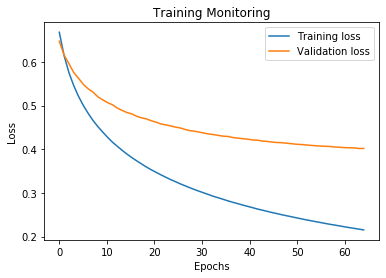

In [29]:
x = np.linspace(0,len(loss_tr_count),len(loss_tr_count))

plt.plot(x, loss_tr_count,label='Training loss')
plt.plot(x, dev_loss_count, label='Validation loss')

plt.title('Training Monitoring')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.show()

Explain here...

**Answer**:

The model have reached at the overfit situation,because the gap between the Training loss and Validation loss is very large. The over-training data result in optimization. In addition, the model's generalization ability performs not well. These conditions cause the error rate of verification set is higher than the traininng set.

Compute accuracy, precision, recall and F1-scores:

In [30]:
# fill in your code...
def accuracy_score(Y_trainerror,pre_te):  
    result = 0
    for i,label in enumerate(Y_trainerror):
        if pre_te[i] == label:
            result = result+1
    score = result/len(Y_trainerror)
    return score

def precision_score(Y_trainerror,pre_te):
    Y_cor = (Y_trainerror==1)
    pre_te_cor = (pre_te==1)
    cor_count = (Y_cor * pre_te_cor).sum()
    all_count = (pre_te==1).sum()
    
    return cor_count/all_count

def recall_score(Y_trainerror,pre_te):
    Y_cor = (Y_trainerror==1)
    pre_te_cor = (pre_te==1)
    cor_count = (Y_cor * pre_te_cor).sum()
    all_count = (Y_cor==1).sum()
    
    return cor_count/all_count

def f1_score(Y_trainerror,pre_te):
    cor_count = 2 * precision_score(Y_trainerror, pre_te) * recall_score(Y_trainerror, pre_te)
    all_count = precision_score(Y_trainerror, pre_te) + recall_score(Y_trainerror, pre_te)
    
    return cor_count/all_count


In [31]:
preds_te_count = predict_class(X_test_count, w_count)
Y_te = data_test_label

print('Accuracy:', accuracy_score(Y_te,preds_te_count))
print('Precision:', precision_score(Y_te,preds_te_count))
print('Recall:', recall_score(Y_te,preds_te_count))
print('F1-Score:', f1_score(Y_te,preds_te_count))

Accuracy: 0.8325
Precision: 0.824390243902439
Recall: 0.845
F1-Score: 0.8345679012345678


Finally, print the top-10 words for the negative and positive class respectively.

In [32]:
# fill in your code...
# Obtain a new dictionary to store the weight
dic_weight = dict()
for i,weight in enumerate(w_count):
    dic_weight[vocab[i]] = weight
    
# Obtain the positive words
dic_resultP = dict()
dic_resultN = dict()

for word,weight in dic_weight.items():
    if weight >= 0:
        dic_resultP[word] = weight
    else:
        dic_resultN[word] = weight

dic_resultP = dict(sorted(dic_resultP.items(),key=lambda weight:weight[1], reverse=True)[:10])
dic_resultN = dict(sorted(dic_resultN.items(),key=lambda weight:weight[1], reverse=False)[:10])

print("The top 10 positive words are %s respectively."% list(dic_resultP.keys()))
print("The top 10 negative words are %s respectively."% list(dic_resultN.keys()))

The top 10 positive words are ['great', 'well', 'also', 'seen', 'life', 'fun', 'world', 'many', 'movies', 'see'] respectively.
The top 10 negative words are ['bad', 'only', 'worst', 'unfortunately', 'script', 'why', 'plot', 'boring', 'any', 'nothing'] respectively.


If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

Provide your answer here...

**Answer**:

We could use this trained features into the different domain such as the shopping reviews or restaurant reviews.

The features like positive category such as 'well' 'good' and negative category such as 'nothing' 'worst' 'unfortunately'.

But we should remove some irrelevant words from the data set.


## Train and Evaluate Logistic Regression with TF.IDF vectors

Follow the same steps as above (i.e. evaluating count n-gram representations).


In [33]:
w_tfidf, trl, devl = SGD(X_tr_tfidf, data_tr_label, 
                         X_dev=X_dev_tfidf, 
                         Y_dev=data_dev_label, 
                         lr=0.0001, 
                         alpha=0.00001, 
                         epochs=50)

Epoch: 0 | Training loss: 0.630729 | Validation loss: 0.597229
Epoch: 1 | Training loss: 0.493460 | Validation loss: 0.549631
Epoch: 2 | Training loss: 0.416168 | Validation loss: 0.518829
Epoch: 3 | Training loss: 0.364288 | Validation loss: 0.496018
Epoch: 4 | Training loss: 0.326064 | Validation loss: 0.478729
Epoch: 5 | Training loss: 0.295907 | Validation loss: 0.464445
Epoch: 6 | Training loss: 0.271674 | Validation loss: 0.453058
Epoch: 7 | Training loss: 0.251322 | Validation loss: 0.443290
Epoch: 8 | Training loss: 0.234251 | Validation loss: 0.434850
Epoch: 9 | Training loss: 0.219420 | Validation loss: 0.427794
Epoch: 10 | Training loss: 0.206445 | Validation loss: 0.421439
Epoch: 11 | Training loss: 0.195075 | Validation loss: 0.415901
Epoch: 12 | Training loss: 0.184735 | Validation loss: 0.411163
Epoch: 13 | Training loss: 0.175831 | Validation loss: 0.406658
Epoch: 14 | Training loss: 0.167590 | Validation loss: 0.402873
Epoch: 15 | Training loss: 0.160046 | Validation l

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

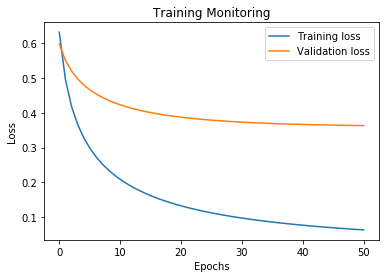

In [34]:
x = np.linspace(0,len(trl),len(trl))

plt.plot(x, trl,label='Training loss')
plt.plot(x, devl, label='Validation loss')

plt.title('Training Monitoring')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.show()

The model have reached at the overfit situation,because the gap between the Training loss and Validation loss is very large.

Compute accuracy, precision, recall and F1-scores:

In [35]:
# fill in your code...
preds_te = predict_class(X_test_tfidf, w_tfidf)
Y_te = data_test_label

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te))
print('Recall:', recall_score(Y_te,preds_te))
print('F1-Score:', f1_score(Y_te,preds_te))

Accuracy: 0.8675
Precision: 0.8516746411483254
Recall: 0.89
F1-Score: 0.8704156479217604


Print top-10 most positive and negative words:

In [36]:
# fill in your code...
# Obtain a new dictionary to store the weight
dic_weight = dict()
for i,weight in enumerate(w_tfidf):
    dic_weight[vocab[i]] = weight
    
# Obtain the positive words
dic_resultP = dict()
dic_resultN = dict()

for word,weight in dic_weight.items():
    if weight >= 0:
        dic_resultP[word] = weight
    else:
        dic_resultN[word] = weight

dic_resultP = dict(sorted(dic_resultP.items(),key=lambda weight:weight[1], reverse=True)[:10])
dic_resultN = dict(sorted(dic_resultN.items(),key=lambda weight:weight[1], reverse=False)[:10])

print("The top 10 positive words are %s respectively."% list(dic_resultP.keys()))
print("The top 10 negative words are %s respectively."% list(dic_resultN.keys()))


The top 10 positive words are ['great', 'hilarious', 'fun', 'terrific', 'overall', 'perfectly', 'definitely', 'memorable', 'life', 'simple'] respectively.
The top 10 negative words are ['bad', 'worst', 'boring', 'supposed', 'unfortunately', 'waste', 'awful', 'poor', 'script', 'nothing'] respectively.


### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

Enter your answer here...

In [38]:
lr_set = [0.001,0.0005,0.0001]
alpha_set = [0.001,0.0005,0.0001]

for lr_sid in range(len(lr_set)):
    for alpha_sid in range(len(alpha_set)):
        w_tfidf, trl, devl = SGD(X_tr_tfidf, data_tr_label, 
                         X_dev=X_dev_tfidf, 
                         Y_dev=data_dev_label, 
                         lr=lr_set[lr_sid], 
                         alpha=alpha_set[alpha_sid], 
                         epochs=50)
        preds_te = predict_class(X_test_tfidf, w_tfidf)
        print("lr = %f, alpha= %f;"%(lr_set[lr_sid],alpha_set[alpha_sid]),'Predict_Class:%f'%(f1_score(Y_te,preds_te)))

Epoch: 0 | Training loss: 0.490848 | Validation loss: 0.422014
Epoch: 1 | Training loss: 0.179338 | Validation loss: 0.378674
Epoch: 2 | Training loss: 0.109270 | Validation loss: 0.371132
Epoch: 3 | Training loss: 0.081879 | Validation loss: 0.365232
Epoch: 4 | Training loss: 0.066032 | Validation loss: 0.363066
Epoch: 5 | Training loss: 0.055511 | Validation loss: 0.363308
lr = 0.001000, alpha= 0.001000; Predict_Class:0.861314
Epoch: 0 | Training loss: 0.492331 | Validation loss: 0.425297
Epoch: 1 | Training loss: 0.176187 | Validation loss: 0.387362
Epoch: 2 | Training loss: 0.109291 | Validation loss: 0.383238
Epoch: 3 | Training loss: 0.081937 | Validation loss: 0.368167
Epoch: 4 | Training loss: 0.065579 | Validation loss: 0.364402
Epoch: 5 | Training loss: 0.055040 | Validation loss: 0.363961
Epoch: 6 | Training loss: 0.047454 | Validation loss: 0.364355
lr = 0.001000, alpha= 0.000500; Predict_Class:0.866337
Epoch: 0 | Training loss: 0.494068 | Validation loss: 0.426704
Epoch: 1

Epoch: 16 | Training loss: 0.153589 | Validation loss: 0.396217
Epoch: 17 | Training loss: 0.147341 | Validation loss: 0.393365
Epoch: 18 | Training loss: 0.141567 | Validation loss: 0.390807
Epoch: 19 | Training loss: 0.136311 | Validation loss: 0.388407
Epoch: 20 | Training loss: 0.131382 | Validation loss: 0.386209
Epoch: 21 | Training loss: 0.126832 | Validation loss: 0.384290
Epoch: 22 | Training loss: 0.122541 | Validation loss: 0.382424
Epoch: 23 | Training loss: 0.118607 | Validation loss: 0.380771
Epoch: 24 | Training loss: 0.114888 | Validation loss: 0.379330
Epoch: 25 | Training loss: 0.111400 | Validation loss: 0.377933
Epoch: 26 | Training loss: 0.108108 | Validation loss: 0.376662
Epoch: 27 | Training loss: 0.105007 | Validation loss: 0.375498
Epoch: 28 | Training loss: 0.102087 | Validation loss: 0.374284
Epoch: 29 | Training loss: 0.099319 | Validation loss: 0.373285
Epoch: 30 | Training loss: 0.096713 | Validation loss: 0.372282
Epoch: 31 | Training loss: 0.094228 | Va

From the previous result, we can find that whtn the lr=0.0001,alpha=0.0001, the value of the F1-Score has reached at the peak.

So we conclude that the lr has more influence on the model training.

If we want to avoid the overfitting, we should apply the regularization.



## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  |  0.825 | 0.85  |  0.83744 |
| BOW-tfidf  |   0.85167 |  0.89 | 0.8704156  |


# Multi-class Logistic Regression 

Now you need to train a Multiclass Logistic Regression (MLR) Classifier by extending the Binary model you developed above. You will use the MLR model to perform topic classification on the AG news dataset consisting of three classes:

- Class 1: World
- Class 2: Sports
- Class 3: Business

You need to follow the same process as in Task 1 for data processing and feature extraction by reusing the functions you wrote.

In [39]:
# fill in your code...
data_tr = pd.read_csv("./data_topic/train.csv",header=None, names=['label','text'])
data_dev = pd.read_csv("./data_topic/dev.csv",header=None, names=['label','text'])
data_test = pd.read_csv("./data_topic/test.csv",header=None, names=['label','text'])

In [40]:
data_tr.head()

,label,text
0,1,Reuters - Venezuelans turned out early\and in ...
1,1,Reuters - South Korean police used water canno...
2,1,Reuters - Thousands of Palestinian\prisoners i...
3,1,AFP - Sporadic gunfire and shelling took place...
4,1,AP - Dozens of Rwandan soldiers flew into Suda...


In [41]:
# We can obtain the all the file into 
data_tr_list = [word.lower() for word in data_tr['text'].tolist()]
data_tr_label = np.array(data_tr['label'])
# development dataset
data_dev_list = [word.lower() for word in data_dev['text'].tolist()]
data_dev_label = np.array(data_dev['label'])
# test dataset
data_test_list = [word.lower() for word in data_test['text'].tolist()]
data_test_label = np.array(data_test['label'])

In [42]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
             'it', 'he', 'she', 'we', 'they' 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what', 
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

In [43]:
tr_ngram = extract_ngrams(data_tr_list, ngram_range=(1,3), stop_words=stop_words)
dev_ngram = extract_ngrams(data_dev_list, ngram_range=(1,3), stop_words=stop_words)
test_ngram = extract_ngrams(data_test_list, ngram_range=(1,3), stop_words=stop_words)

In [44]:
vocab, df, ngram_counts = get_vocab(data_tr_list, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(list(df.items())[:10])
# print(df.most_common()[:10])

5000

['reuters', 'said', 'tuesday', 'wednesday', 'new', 'after', 'ap', 'athens', 'monday', 'first', 'two', 'york', 'over', ('new', 'york'), 'us', 'olympic', 'but', 'their', 'will', 'inc', 'more', 'year', 'oil', 'prices', 'company', 'world', 'than', 'aug', 'about', 'had', 'united', 'one', 'sunday', 'out', 'into', 'against', 'up', 'second', 'last', 'president', 'stocks', 'gold', 'team', ('york', 'reuters'), ('new', 'york', 'reuters'), 'when', 'three', 'night', 'time', 'no', 'yesterday', 'games', 'olympics', 'not', 'states', 'greece', 'off', 'iraq', 'washington', 'percent', ('united', 'states'), ('oil', 'prices'), 'home', 'day', 'google', 'public', ('athens', 'reuters'), 'record', 'week', 'men', 'government', 'win', ('said', 'tuesday'), 'american', 'won', 'years', 'all', 'billion', 'shares', 'city', 'offering', 'officials', 'would', 'today', 'final', 'afp', 'gt', 'people', 'lt', 'medal', 'corp', 'sales', 'country', 'back', 'four', 'high', 'investor', 'com', 'minister', 'reported']

[('re

In [45]:
# Vectorise
X_tr_count = vectorise(tr_ngram,vocab)
X_dev_count = vectorise(dev_ngram,vocab)
X_test_count = vectorise(test_ngram,vocab)

#Show
X_tr_count[:2,:50]

array([[1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]])

Tf.idf Part

In [46]:
X_tr_tfidf = tfidf_function(X_count=X_tr_count, ngram_list = tr_ngram, vocab = vocab)
X_dev_tfidf = tfidf_function(X_count=X_dev_count, ngram_list = dev_ngram, vocab = vocab)
X_test_tfidf = tfidf_function(X_count=X_test_count, ngram_list = test_ngram, vocab = vocab)

Now you need to change `SGD` to support multiclass datasets. First you need to develop a `softmax` function. It takes as input:

- `z`: array of real numbers 

and returns:

- `smax`: the softmax of `z`

In [47]:
def softmax(z):

    if len(z.shape) >1:
        x_sum = np.sum(np.exp(z), axis = 1, keepdims = True)
    else:
        x_sum = np.sum(np.exp(z), axis = 0)

    smax = np.exp(z) / x_sum    
    return smax

Then modify `predict_proba` and `predict_class` functions for the multiclass case:

In [48]:
def predict_proba(X, weights):
    
    P_value = np.dot(X,weights.T)
    preds_proba = softmax(P_value)
    
    return preds_proba

In [49]:
def predict_class(X, weights):
    
    pro_value = predict_proba(X,weights)
    if len(pro_value.shape)>1:
        feature_list = list()
        for value in pro_value:
            value[value ==  max(value)] = 1
            for i,row in enumerate(value):
                if row == 1:
                    feature_list.append(i+1)
                    break;
        feature_list = np.asarray(feature_list)
        
    else:
        pro_value[pro_value==max(pro_value)] = 1
        for i,value in enumerate(pro_value):
            if value == 1:
                feature_list = i+1
                break;
    
    return feature_list

Toy example and expected functionality of the functions above:

In [50]:
X = np.array([[0.1,0.2],[0.2,0.1],[0.1,-0.2]])
w = np.array([[2,-5],[-5,2]])

In [51]:
predict_proba(X, w)

array([[0.33181223, 0.66818777],
       [0.66818777, 0.33181223],
       [0.89090318, 0.10909682]])

In [52]:
predict_class(X, w)

array([2, 1, 1])

Now you need to compute the categorical cross entropy loss (extending the binary loss to support multiple classes).

In [53]:
def categorical_loss(X, Y, weights, num_classes=5, alpha=0.00001):
    
    y_proba = predict_proba(X,weights)
    # Use the np.clip to restrict the value range
    y_proba = np.clip(y_proba,alpha,1-alpha)
    
    if len(X.shape)>1:
        loss_value = -np.log(y_proba[range(len(Y)),Y-1])
        L2_reg_value = (1/len(X))*(alpha/2)*(np.sum(np.square(weights)))
    else:
        loss_value = -np.log(y_proba[Y-1])
        L2_reg_value = (alpha/2)*(np.sum(np.square(weights)))
    
    l = loss_value + L2_reg_value
    return l
    

In [54]:
def one_regularize(X,class_nums):
    
    return np.delete(np.eye(class_nums+1)[X],0,axis=1)

Finally you need to modify SGD to support the categorical cross entropy loss:

In [55]:
def SGD(X_tr, Y_tr, vocab, X_dev=[], Y_dev=[], num_classes=5, lr=0.01, alpha=0.00001, epochs=5, tolerance=0.001, print_progress=True):
        
    cur_loss_dev = 2.
    training_loss_history = []
    validation_loss_history = []

    # Obtain the weights
    weights = np.zeros((3, len(vocab)))
    Y_tr_onehot = one_regularize(Y_tr,num_classes)
    
    for i in range(epochs):
        loss_list = list()
        seed_number = random.randint(50,100)
        np.random.seed(seed_number)
        # Shuffle the X_tr and Y_tr  
        per_X_tr = np.random.permutation(X_tr)
        np.random.seed(seed_number)
        per_Y_tr = np.random.permutation(Y_tr)
        np.random.seed(seed_number)
        per_Y_tr_onehot = np.random.permutation(Y_tr_onehot)

        for j,row in enumerate(per_X_tr):
            # Caculate the categorical_loss and store the loss into loss_list
            loss_tr = categorical_loss(row, per_Y_tr[j], weights, alpha)
            loss_list.append(loss_tr)
            y_pred = predict_proba(row,weights) 
            error = y_pred - per_Y_tr_onehot[j]
            # update weights
            weights_list = [weights[i]-lr*row*error[i] for i in range(num_classes)]
            weights = np.asarray(weights_list)
        
        # Obtain the mean
        tr_loss_mean = np.mean(loss_list)
        training_loss_history.append(tr_loss_mean)
        
        dev_loss = categorical_loss(X_dev, Y_dev, weights, alpha)
        dev_loss = sum(dev_loss)/len(dev_loss)
        validation_loss_history.append(dev_loss)
        print('Epoch: %d' % i, '| Training loss: %f' %tr_loss_mean, '| Validation loss: %f' %dev_loss)
        
        if (cur_loss_dev-dev_loss)<tolerance:
            break       
        cur_loss_dev = dev_loss


    return weights, training_loss_history, validation_loss_history

Now you are ready to train and evaluate you MLR following the same steps as in Task 1 for both Count and tfidf features:

In [56]:
w_count, loss_tr_count, dev_loss_count = SGD(X_tr_count, data_tr_label,vocab,
                                             X_dev=X_dev_count, 
                                             Y_dev=data_dev_label,
                                             num_classes=3,
                                             lr=0.0001, 
                                             alpha=0.001, 
                                             epochs=200)

Epoch: 0 | Training loss: 1.084229 | Validation loss: 1.083282
Epoch: 1 | Training loss: 1.056024 | Validation loss: 1.069042
Epoch: 2 | Training loss: 1.030918 | Validation loss: 1.055699
Epoch: 3 | Training loss: 1.008251 | Validation loss: 1.043099
Epoch: 4 | Training loss: 0.987531 | Validation loss: 1.031134
Epoch: 5 | Training loss: 0.968390 | Validation loss: 1.019712
Epoch: 6 | Training loss: 0.950563 | Validation loss: 1.008770
Epoch: 7 | Training loss: 0.933864 | Validation loss: 0.998258
Epoch: 8 | Training loss: 0.918148 | Validation loss: 0.988138
Epoch: 9 | Training loss: 0.903305 | Validation loss: 0.978378
Epoch: 10 | Training loss: 0.889241 | Validation loss: 0.968950
Epoch: 11 | Training loss: 0.875882 | Validation loss: 0.959835
Epoch: 12 | Training loss: 0.863166 | Validation loss: 0.951012
Epoch: 13 | Training loss: 0.851038 | Validation loss: 0.942466
Epoch: 14 | Training loss: 0.839455 | Validation loss: 0.934182
Epoch: 15 | Training loss: 0.828375 | Validation l

Epoch: 128 | Training loss: 0.433476 | Validation loss: 0.581021
Epoch: 129 | Training loss: 0.432154 | Validation loss: 0.579771
Epoch: 130 | Training loss: 0.430844 | Validation loss: 0.578532
Epoch: 131 | Training loss: 0.429546 | Validation loss: 0.577305
Epoch: 132 | Training loss: 0.428260 | Validation loss: 0.576089
Epoch: 133 | Training loss: 0.426985 | Validation loss: 0.574884
Epoch: 134 | Training loss: 0.425722 | Validation loss: 0.573691
Epoch: 135 | Training loss: 0.424471 | Validation loss: 0.572509
Epoch: 136 | Training loss: 0.423230 | Validation loss: 0.571338
Epoch: 137 | Training loss: 0.422000 | Validation loss: 0.570178
Epoch: 138 | Training loss: 0.420782 | Validation loss: 0.569028
Epoch: 139 | Training loss: 0.419573 | Validation loss: 0.567889
Epoch: 140 | Training loss: 0.418376 | Validation loss: 0.566760
Epoch: 141 | Training loss: 0.417188 | Validation loss: 0.565641
Epoch: 142 | Training loss: 0.416011 | Validation loss: 0.564532
Epoch: 143 | Training los

Plot training and validation process and explain if your model overfit, underfit or is about right:

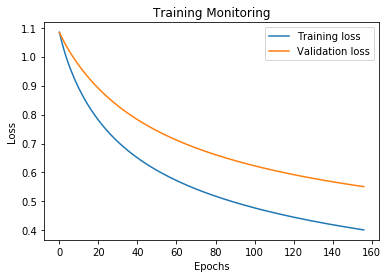

In [57]:
x = np.linspace(0,len(loss_tr_count),len(loss_tr_count))
y1, y2 = loss_tr_count, dev_loss_count
 
plt.plot(x, y1,label='Training loss')
plt.plot(x, y2, label='Validation loss')
 
plt.title('Training Monitoring')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.show()

The model is overfit

Compute accuracy, precision, recall and F1-scores:

In [58]:
# fill in your code...
preds_te_count = predict_class(X = X_test_count, weights = w_count)
Y_te = data_test_label

print('Accuracy:', accuracy_score(Y_te,preds_te_count))
print('Precision:', precision_score(Y_te,preds_te_count))
print('Recall:', recall_score(Y_te,preds_te_count))
print('F1-Score:', f1_score(Y_te,preds_te_count))

Accuracy: 0.8533333333333334
Precision: 0.8233333333333334
Recall: 0.8233333333333334
F1-Score: 0.8233333333333334


Print the top-10 words for each class respectively.

In [59]:
for i in range(len(w_count)):
    
    dict_store = {vocab[sid]:weight for sid,weight in enumerate(w_count[i])}
    # Order By
    dict_store = dict(sorted(dict_store.items(), key=lambda col:col[1],reverse=True)[:10])

    print("The top 10 words for class %d are %s respectively."%(i+1,list(dict_store.keys())))

The top 10 words for class 1 are ['afp', 'said', 'president', 'minister', 'najaf', 'people', 'monday', 'iraq', 'troops', 'al'] respectively.
The top 10 words for class 2 are ['athens', 'olympic', 'ap', 'team', ('athens', 'reuters'), 'win', 'games', 'olympics', 'game', 'when'] respectively.
The top 10 words for class 3 are ['company', 'inc', 'oil', 'corp', 'billion', 'prices', 'business', 'sales', 'million', 'market'] respectively.


### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

Explain here...

In [62]:
lr_set = [0.001,0.0005,0.0001]
alpha_set = [0.001,0.0005,0.0001]

for lr_sid in range(len(lr_set)):
    for alpha_sid in range(len(alpha_set)):
        w_count, loss_tr_count, dev_loss_count = SGD(X_tr_count, data_tr_label,vocab,
                                             X_dev=X_dev_count, 
                                             Y_dev=data_dev_label,
                                             num_classes=3,
                                             lr=lr_set[lr_sid], 
                                             alpha=alpha_set[alpha_sid], 
                                             epochs=200)
        preds_te = predict_class(X = X_test_count, weights = w_count)
        print("lr = %f, alpha= %f;"%(lr_set[lr_sid],alpha_set[alpha_sid]),'Predict_Class:%f'%(f1_score(Y_te,preds_te)))

Epoch: 0 | Training loss: 0.990362 | Validation loss: 0.977769
Epoch: 1 | Training loss: 0.840230 | Validation loss: 0.895535
Epoch: 2 | Training loss: 0.747093 | Validation loss: 0.833415
Epoch: 3 | Training loss: 0.681181 | Validation loss: 0.784788
Epoch: 4 | Training loss: 0.631315 | Validation loss: 0.745370
Epoch: 5 | Training loss: 0.591804 | Validation loss: 0.712715
Epoch: 6 | Training loss: 0.559436 | Validation loss: 0.685196
Epoch: 7 | Training loss: 0.532167 | Validation loss: 0.661514
Epoch: 8 | Training loss: 0.508784 | Validation loss: 0.640886
Epoch: 9 | Training loss: 0.488371 | Validation loss: 0.622766
Epoch: 10 | Training loss: 0.470339 | Validation loss: 0.606647
Epoch: 11 | Training loss: 0.454241 | Validation loss: 0.592179
Epoch: 12 | Training loss: 0.439729 | Validation loss: 0.579122
Epoch: 13 | Training loss: 0.426550 | Validation loss: 0.567233
Epoch: 14 | Training loss: 0.414496 | Validation loss: 0.556338
Epoch: 15 | Training loss: 0.403425 | Validation l

Epoch: 50 | Training loss: 0.235477 | Validation loss: 0.402190
Epoch: 51 | Training loss: 0.233141 | Validation loss: 0.400315
Epoch: 52 | Training loss: 0.230861 | Validation loss: 0.398472
Epoch: 53 | Training loss: 0.228646 | Validation loss: 0.396730
Epoch: 54 | Training loss: 0.226478 | Validation loss: 0.395014
Epoch: 55 | Training loss: 0.224364 | Validation loss: 0.393375
Epoch: 56 | Training loss: 0.222299 | Validation loss: 0.391754
Epoch: 57 | Training loss: 0.220282 | Validation loss: 0.390183
Epoch: 58 | Training loss: 0.218312 | Validation loss: 0.388654
Epoch: 59 | Training loss: 0.216383 | Validation loss: 0.387165
Epoch: 60 | Training loss: 0.214498 | Validation loss: 0.385720
Epoch: 61 | Training loss: 0.212653 | Validation loss: 0.384299
Epoch: 62 | Training loss: 0.210850 | Validation loss: 0.382920
Epoch: 63 | Training loss: 0.209081 | Validation loss: 0.381562
Epoch: 64 | Training loss: 0.207351 | Validation loss: 0.380262
Epoch: 65 | Training loss: 0.205654 | Va

Epoch: 20 | Training loss: 0.473697 | Validation loss: 0.614907
Epoch: 21 | Training loss: 0.465223 | Validation loss: 0.607072
Epoch: 22 | Training loss: 0.457203 | Validation loss: 0.599632
Epoch: 23 | Training loss: 0.449596 | Validation loss: 0.592581
Epoch: 24 | Training loss: 0.442369 | Validation loss: 0.585893
Epoch: 25 | Training loss: 0.435484 | Validation loss: 0.579515
Epoch: 26 | Training loss: 0.428920 | Validation loss: 0.573444
Epoch: 27 | Training loss: 0.422646 | Validation loss: 0.567651
Epoch: 28 | Training loss: 0.416641 | Validation loss: 0.562120
Epoch: 29 | Training loss: 0.410890 | Validation loss: 0.556818
Epoch: 30 | Training loss: 0.405368 | Validation loss: 0.551737
Epoch: 31 | Training loss: 0.400064 | Validation loss: 0.546861
Epoch: 32 | Training loss: 0.394961 | Validation loss: 0.542181
Epoch: 33 | Training loss: 0.390050 | Validation loss: 0.537682
Epoch: 34 | Training loss: 0.385314 | Validation loss: 0.533345
Epoch: 35 | Training loss: 0.380743 | Va

Epoch: 48 | Training loss: 0.332858 | Validation loss: 0.485956
Epoch: 49 | Training loss: 0.329858 | Validation loss: 0.483297
Epoch: 50 | Training loss: 0.326931 | Validation loss: 0.480699
Epoch: 51 | Training loss: 0.324078 | Validation loss: 0.478177
Epoch: 52 | Training loss: 0.321292 | Validation loss: 0.475705
Epoch: 53 | Training loss: 0.318579 | Validation loss: 0.473316
Epoch: 54 | Training loss: 0.315924 | Validation loss: 0.470977
Epoch: 55 | Training loss: 0.313334 | Validation loss: 0.468708
Epoch: 56 | Training loss: 0.310800 | Validation loss: 0.466493
Epoch: 57 | Training loss: 0.308325 | Validation loss: 0.464332
Epoch: 58 | Training loss: 0.305903 | Validation loss: 0.462223
Epoch: 59 | Training loss: 0.303533 | Validation loss: 0.460165
Epoch: 60 | Training loss: 0.301214 | Validation loss: 0.458150
Epoch: 61 | Training loss: 0.298943 | Validation loss: 0.456184
Epoch: 62 | Training loss: 0.296720 | Validation loss: 0.454257
Epoch: 63 | Training loss: 0.294540 | Va

Epoch: 77 | Training loss: 0.268033 | Validation loss: 0.429788
Epoch: 78 | Training loss: 0.266380 | Validation loss: 0.428401
Epoch: 79 | Training loss: 0.264754 | Validation loss: 0.427046
Epoch: 80 | Training loss: 0.263154 | Validation loss: 0.425708
Epoch: 81 | Training loss: 0.261581 | Validation loss: 0.424396
Epoch: 82 | Training loss: 0.260031 | Validation loss: 0.423106
Epoch: 83 | Training loss: 0.258506 | Validation loss: 0.421835
Epoch: 84 | Training loss: 0.257005 | Validation loss: 0.420589
Epoch: 85 | Training loss: 0.255526 | Validation loss: 0.419363
Epoch: 86 | Training loss: 0.254071 | Validation loss: 0.418162
Epoch: 87 | Training loss: 0.252637 | Validation loss: 0.416987
Epoch: 88 | Training loss: 0.251224 | Validation loss: 0.415823
Epoch: 89 | Training loss: 0.249832 | Validation loss: 0.414680
Epoch: 90 | Training loss: 0.248459 | Validation loss: 0.413554
Epoch: 91 | Training loss: 0.247107 | Validation loss: 0.412450
Epoch: 92 | Training loss: 0.245774 | Va

Epoch: 106 | Training loss: 0.466128 | Validation loss: 0.611982
Epoch: 107 | Training loss: 0.464476 | Validation loss: 0.610413
Epoch: 108 | Training loss: 0.462841 | Validation loss: 0.608860
Epoch: 109 | Training loss: 0.461224 | Validation loss: 0.607325
Epoch: 110 | Training loss: 0.459624 | Validation loss: 0.605806
Epoch: 111 | Training loss: 0.458042 | Validation loss: 0.604303
Epoch: 112 | Training loss: 0.456476 | Validation loss: 0.602817
Epoch: 113 | Training loss: 0.454927 | Validation loss: 0.601347
Epoch: 114 | Training loss: 0.453394 | Validation loss: 0.599892
Epoch: 115 | Training loss: 0.451877 | Validation loss: 0.598452
Epoch: 116 | Training loss: 0.450375 | Validation loss: 0.597028
Epoch: 117 | Training loss: 0.448889 | Validation loss: 0.595618
Epoch: 118 | Training loss: 0.447418 | Validation loss: 0.594222
Epoch: 119 | Training loss: 0.445961 | Validation loss: 0.592840
Epoch: 120 | Training loss: 0.444519 | Validation loss: 0.591473
Epoch: 121 | Training los

Epoch: 77 | Training loss: 0.523939 | Validation loss: 0.666763
Epoch: 78 | Training loss: 0.521551 | Validation loss: 0.664511
Epoch: 79 | Training loss: 0.519197 | Validation loss: 0.662289
Epoch: 80 | Training loss: 0.516877 | Validation loss: 0.660099
Epoch: 81 | Training loss: 0.514590 | Validation loss: 0.657939
Epoch: 82 | Training loss: 0.512335 | Validation loss: 0.655807
Epoch: 83 | Training loss: 0.510111 | Validation loss: 0.653704
Epoch: 84 | Training loss: 0.507918 | Validation loss: 0.651629
Epoch: 85 | Training loss: 0.505755 | Validation loss: 0.649581
Epoch: 86 | Training loss: 0.503620 | Validation loss: 0.647561
Epoch: 87 | Training loss: 0.501514 | Validation loss: 0.645566
Epoch: 88 | Training loss: 0.499435 | Validation loss: 0.643596
Epoch: 89 | Training loss: 0.497384 | Validation loss: 0.641652
Epoch: 90 | Training loss: 0.495359 | Validation loss: 0.639733
Epoch: 91 | Training loss: 0.493361 | Validation loss: 0.637837
Epoch: 92 | Training loss: 0.491387 | Va

Epoch: 48 | Training loss: 0.613711 | Validation loss: 0.749830
Epoch: 49 | Training loss: 0.609727 | Validation loss: 0.746229
Epoch: 50 | Training loss: 0.605828 | Validation loss: 0.742695
Epoch: 51 | Training loss: 0.602009 | Validation loss: 0.739225
Epoch: 52 | Training loss: 0.598269 | Validation loss: 0.735819
Epoch: 53 | Training loss: 0.594603 | Validation loss: 0.732473
Epoch: 54 | Training loss: 0.591010 | Validation loss: 0.729187
Epoch: 55 | Training loss: 0.587488 | Validation loss: 0.725959
Epoch: 56 | Training loss: 0.584033 | Validation loss: 0.722786
Epoch: 57 | Training loss: 0.580644 | Validation loss: 0.719667
Epoch: 58 | Training loss: 0.577319 | Validation loss: 0.716602
Epoch: 59 | Training loss: 0.574055 | Validation loss: 0.713587
Epoch: 60 | Training loss: 0.570850 | Validation loss: 0.710623
Epoch: 61 | Training loss: 0.567703 | Validation loss: 0.707707
Epoch: 62 | Training loss: 0.564612 | Validation loss: 0.704839
Epoch: 63 | Training loss: 0.561575 | Va

From the previous result, we can see that as decreasing the value of lr and alpha, the F1-Score is increasing.

In conclusion,the both lr and alpha has the great impact the training model.

### Now evaluate BOW-tfidf...

In [63]:
w_count, loss_tr_count, dev_loss_count = SGD(X_tr_tfidf, data_tr_label,vocab,
                                             X_dev=X_dev_tfidf, 
                                             Y_dev=data_dev_label,
                                             num_classes=3,
                                             lr=0.0001, 
                                             alpha=0.001, 
                                             epochs=200)

Epoch: 0 | Training loss: 0.959970 | Validation loss: 0.957439
Epoch: 1 | Training loss: 0.763611 | Validation loss: 0.867650
Epoch: 2 | Training loss: 0.650473 | Validation loss: 0.803574
Epoch: 3 | Training loss: 0.574929 | Validation loss: 0.754995
Epoch: 4 | Training loss: 0.520227 | Validation loss: 0.716595
Epoch: 5 | Training loss: 0.478179 | Validation loss: 0.685185
Epoch: 6 | Training loss: 0.444663 | Validation loss: 0.659090
Epoch: 7 | Training loss: 0.417000 | Validation loss: 0.636840
Epoch: 8 | Training loss: 0.393671 | Validation loss: 0.617503
Epoch: 9 | Training loss: 0.373643 | Validation loss: 0.600592
Epoch: 10 | Training loss: 0.356148 | Validation loss: 0.585546
Epoch: 11 | Training loss: 0.340754 | Validation loss: 0.572148
Epoch: 12 | Training loss: 0.327017 | Validation loss: 0.560089
Epoch: 13 | Training loss: 0.314632 | Validation loss: 0.549119
Epoch: 14 | Training loss: 0.303426 | Validation loss: 0.539062
Epoch: 15 | Training loss: 0.293215 | Validation l

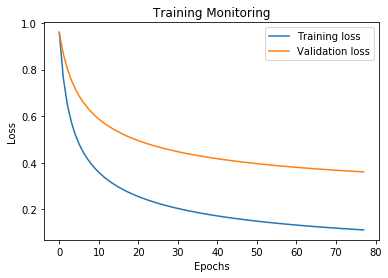

In [64]:
x = np.linspace(0,len(loss_tr_count),len(loss_tr_count))
y1, y2 = loss_tr_count, dev_loss_count
 
plt.plot(x, y1,label='Training loss')
plt.plot(x, y2, label='Validation loss')
 
plt.title('Training Monitoring')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.show()

The model is overfit

In [65]:
preds_te_count = predict_class(X = X_test_count, weights = w_count)
Y_te = data_test_label

print('Accuracy:', accuracy_score(Y_te,preds_te_count))
print('Precision:', precision_score(Y_te,preds_te_count))
print('Recall:', recall_score(Y_te,preds_te_count))
print('F1-Score:', f1_score(Y_te,preds_te_count))

Accuracy: 0.8755555555555555
Precision: 0.8417508417508418
Recall: 0.8333333333333334
F1-Score: 0.8375209380234506


## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  |  0.8233 |  0.8233 | 0.8233 |
| BOW-tfidf  | 0.8417  |  0.8333 | 0.8375  |
